## Credit_Risk_Modeling_04_EAD_LGD

### In this Notebook:


### EAD: Exposure at Default is predicted using a multivariate regression.

    * Exposure at Default = Credit Conversion Factor * Funded Amount

EAD and funded amount are in the dataset so we calculate the Credit Conversion Factor for each loan and use it as the target variable in the multivariate regression.  The model output will enable us to predict the expected EAD for new loans.     

### LGD: Loss Given Default as a percentage is predicted using a 2 stage process:
    
    * Stage 1: A Logistic Regression predicting whether the Recovery Rate = 0 (same as loss 100%)  
    * Stage 2: A Multivariate Linear Regression

We take the product of stage 1 & stage 2 to generate expected Loss Given Fault for new loans

### Bringing it all Together

The EAD & LGD results are combined with the Probability of Default (PD) model results into a single dataframe.
Expected Loss EL is calculated for each loan as a product of three components, Probability of Default, Exposure at Default and Loss Given Default.  

The Expected Losses are summed across all loans giving total Expected Loss, or Regulatory Capital Requirement.

The Total Funded Amount / Exposure is calculated: 

The Capital Ratio which is the Capital Requirement as a percentage of Loans is calculated:

### Input files:
Pickled as output from running the previous notebooks in sequence 00-03.

    loan_data_2007_2014_preprocessed.pkl
    loan_data_inputs_train.pkl
    loan_data_inputs_test.pkl
    pd_model.sav

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import pickle
%load_ext autoreload
%reload_ext autoreload
import clockwork_orange as clockwork

# Import Data

Let's import the loan_data_2007_2014_preprocessed dataset that was generated by credit_risk_modeling_01_preprocessing.ipynb

In [2]:
loan_data_preprocessed_backup = pd.read_pickle('../data/loan_data_2007_2014_preprocessed.pkl')


# Explore Data

In [3]:
loan_data_preprocessed = loan_data_preprocessed_backup.copy()

In [4]:
loan_data_preprocessed.columns.values

array(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan',
       'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim', 'vix_mean', 'vix_min', 'vix_max', 'vix_spread',
       'year

In [5]:
loan_data_preprocessed.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,payment_to_inc
0,0,1077501,1296599,5000,5000,4975,36,10.65,162.869995,B,...,0,0,0,0,0,0,0,1,0,8.143500
1,1,1077430,1314167,2500,2500,2500,60,15.27,59.830002,C,...,0,0,0,0,0,0,0,1,0,2.393200
2,2,1077175,1313524,2400,2400,2400,36,15.96,84.330002,C,...,0,0,0,0,0,0,0,1,0,8.259549
3,3,1076863,1277178,10000,10000,10000,36,13.49,339.309998,C,...,0,0,0,0,0,0,0,1,0,8.275854
4,4,1075358,1311748,3000,3000,3000,60,12.69,67.790001,B,...,0,0,0,0,0,0,0,1,0,1.016850


In [6]:
loan_data_preprocessed.tail()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,payment_to_inc
466280,466280,8598660,1440975,18400,18400,18400,60,14.470000,432.640015,C,...,0,0,0,0,0,0,0,0,1,4.719709
466281,466281,9684700,11536848,22000,22000,22000,60,19.969999,582.500000,D,...,0,0,0,0,0,0,0,1,0,8.961538
466282,466282,9584776,11436914,20700,20700,20700,60,16.990000,514.340027,D,...,0,0,0,0,0,0,0,1,0,13.417565
466283,466283,9604874,11457002,2000,2000,2000,36,7.900000,62.590000,A,...,0,0,0,0,0,0,0,0,1,0.904916
466284,466284,9199665,11061576,10000,10000,9975,36,19.200001,367.579987,D,...,0,0,0,0,0,0,0,1,0,9.589044


In [7]:
loan_data_defaults = loan_data_preprocessed[loan_data_preprocessed['loan_status'].isin(['Charged Off','Does not meet the credit policy. Status:Charged Off'])]
# Here we take only the accounts that were charged-off (written-off).

In [8]:
loan_data_defaults.shape

(43236, 195)

In [9]:
pd.options.display.max_rows = None
# Sets the pandas dataframe options to display all columns/ rows.

In [10]:
loan_data_defaults.isnull().sum()

Unnamed: 0                                                             0
id                                                                     0
member_id                                                              0
loan_amnt                                                              0
funded_amnt                                                            0
funded_amnt_inv                                                        0
term                                                                   0
int_rate                                                               0
installment                                                            0
grade                                                                  0
sub_grade                                                              0
emp_length                                                          2337
home_ownership                                                         0
annual_inc                                         

# Independent Variables

In [11]:
loan_data_defaults['mths_since_last_delinq'].fillna(0, inplace = True)
# We fill the missing values with zeroes.

C:\Users\User1\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [12]:
#loan_data_defaults['mths_since_last_delinq'].fillna(loan_data_defaults['mths_since_last_delinq'].max() + 12, inplace=True)

In [13]:
loan_data_defaults['mths_since_last_record'].fillna(0, inplace=True)
# We fill the missing values with zeroes.

# Dependent Variables

In order to calculate the target variable for LGD, we first have to calculate the Recovery Rate of defaulted accounts, which is the amount of recoveries divided by the funded amount.

In [14]:
loan_data_defaults['recovery_rate'] = loan_data_defaults['recoveries'] / loan_data_defaults['funded_amnt']

C:\Users\User1\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Lets take a look at the descriptive statistics: We are looking for any outliers above 1 or below 0, which will need to be adjusted. 

In [15]:
loan_data_defaults['recovery_rate'].describe()

count    43236.000000
mean         0.060820
std          0.089770
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.220774
Name: recovery_rate, dtype: float64

Adjusting for outliers:

In [16]:
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] > 1, 1, loan_data_defaults['recovery_rate'])
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] < 0, 0, loan_data_defaults['recovery_rate'])

C:\Users\User1\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\User1\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
loan_data_defaults['recovery_rate'].describe()

count    43236.000000
mean         0.060770
std          0.089202
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.000000
Name: recovery_rate, dtype: float64

### Calculating the Credit Conversion Factor CCR
The Credit Conversion Factor = Total Funded Amount - Repayments of Principle divided by Total Funded Amount.
It represents the percentage of the loan outstanding.

In [18]:
loan_data_defaults['CCF'] = (loan_data_defaults['funded_amnt'] - loan_data_defaults['total_rec_prncp']) / loan_data_defaults['funded_amnt']

C:\Users\User1\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Descriptive Stats for Credit Conversion Factor

In [19]:
loan_data_defaults['CCF'].describe()

count    43236.000000
mean         0.735952
std          0.200742
min          0.000438
25%          0.632088
50%          0.789908
75%          0.888543
max          1.000000
Name: CCF, dtype: float64

Save the output down in a pickle format

In [20]:
loan_data_defaults.to_pickle('../loan_data_defaults.pkl')

# Explore Dependent Variables

Recovery Rate are bounded between 0 and 1 and often distributed around a mean of 10-20%. When borrowers default on a loan it is usually because they can't pay, and there is little to recover through legal means, or the costs of recovery for the lender are too high.
As such we expect to see RR with a mean around 10%

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

(array([2.0651e+04, 3.7200e+02, 6.4200e+02, 1.1950e+03, 1.9300e+03,
        1.9430e+03, 6.4500e+02, 7.4900e+02, 8.9700e+02, 1.2360e+03,
        1.5530e+03, 1.7910e+03, 2.3140e+03, 2.4510e+03, 1.0410e+03,
        6.7200e+02, 7.0600e+02, 4.7300e+02, 1.9600e+02, 2.1000e+02,
        1.8600e+02, 1.5500e+02, 1.5900e+02, 1.1500e+02, 5.6000e+01,
        6.1000e+01, 4.2000e+01, 5.1000e+01, 4.6000e+01, 3.5000e+01,
        4.0000e+01, 3.3000e+01, 2.9000e+01, 2.5000e+01, 3.2000e+01,
        4.0000e+01, 2.7000e+01, 3.0000e+01, 1.6000e+01, 1.4000e+01,
        2.7000e+01, 2.0000e+01, 1.7000e+01, 1.0000e+01, 6.0000e+00,
        1.1000e+01, 5.0000e+00, 1.0000e+01, 1.1000e+01, 9.0000e+00,
        1.2000e+01, 1.1000e+01, 9.0000e+00, 8.0000e+00, 3.0000e+00,
        4.0000e+00, 3.0000e+00, 8.0000e+00, 2.0000e+00, 5.0000e+00,
        3.0000e+00, 5.0000e+00, 5.0000e+00, 2.0000e+00, 4.0000e+00,
        3.0000e+00, 6.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00,
        6.0000e+00, 4.0000e+00, 4.0000e+00, 2.00

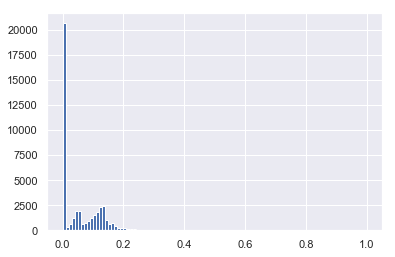

In [22]:
plt.hist(loan_data_defaults['recovery_rate'], bins = 100)

(array([2.1023e+04, 1.8370e+03, 3.8730e+03, 1.3940e+03, 2.1330e+03,
        3.3440e+03, 4.7650e+03, 1.7130e+03, 1.1790e+03, 4.0600e+02,
        3.4100e+02, 2.7400e+02, 1.1700e+02, 9.3000e+01, 8.1000e+01,
        7.3000e+01, 5.4000e+01, 7.2000e+01, 5.7000e+01, 3.0000e+01,
        4.7000e+01, 2.7000e+01, 1.7000e+01, 1.5000e+01, 2.0000e+01,
        2.3000e+01, 1.7000e+01, 7.0000e+00, 1.1000e+01, 7.0000e+00,
        8.0000e+00, 7.0000e+00, 7.0000e+00, 8.0000e+00, 7.0000e+00,
        1.0000e+01, 6.0000e+00, 1.1000e+01, 9.0000e+00, 9.0000e+00,
        6.0000e+00, 6.0000e+00, 6.0000e+00, 3.0000e+00, 9.0000e+00,
        9.0000e+00, 1.5000e+01, 8.0000e+00, 9.0000e+00, 3.3000e+01]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.

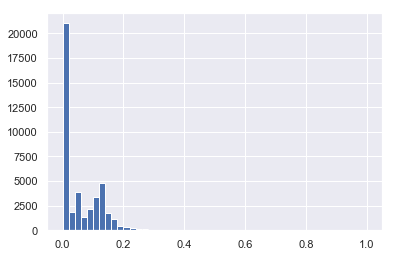

In [23]:
plt.hist(loan_data_defaults['recovery_rate'], bins = 50)

#### Credit Conversion Ratio:
When borrowers default it tends to be when there is a larger percentage of the loan outstanding.  When there is a small portion of the balance outstanding responsible borrowers may find a way of avoiding default.

Check out the histogram below

(array([  20.,   60.,   29.,   97.,   70.,   84.,  150.,   78.,  124.,
         170.,  152.,  208.,  199.,  228.,  242.,  276.,  300.,  335.,
         339.,  376.,  412.,  421.,  505.,  505.,  575.,  583.,  614.,
         735.,  756.,  812.,  840.,  942.,  959., 1137., 1217., 1418.,
        1431., 1580., 1732., 1850., 2003., 2151., 2123., 2376., 2447.,
        2693., 2366., 2115., 1527.,  874.]),
 array([4.3800000e-04, 2.0429240e-02, 4.0420480e-02, 6.0411720e-02,
        8.0402960e-02, 1.0039420e-01, 1.2038544e-01, 1.4037668e-01,
        1.6036792e-01, 1.8035916e-01, 2.0035040e-01, 2.2034164e-01,
        2.4033288e-01, 2.6032412e-01, 2.8031536e-01, 3.0030660e-01,
        3.2029784e-01, 3.4028908e-01, 3.6028032e-01, 3.8027156e-01,
        4.0026280e-01, 4.2025404e-01, 4.4024528e-01, 4.6023652e-01,
        4.8022776e-01, 5.0021900e-01, 5.2021024e-01, 5.4020148e-01,
        5.6019272e-01, 5.8018396e-01, 6.0017520e-01, 6.2016644e-01,
        6.4015768e-01, 6.6014892e-01, 6.8014016e-01, 7.0

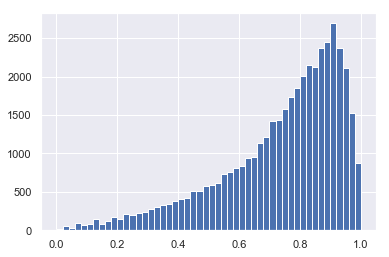

In [24]:
plt.hist(loan_data_defaults['CCF'], bins = 50)

Create a target variable of [0,1] for loan with recovery rates = 0 and recovery rates <> 0 for the RR Logistic Regression

In [25]:
loan_data_defaults['recovery_rate_0_1'] = np.where(loan_data_defaults['recovery_rate'] == 0, 0, 1)

C:\Users\User1\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
loan_data_defaults['recovery_rate_0_1']

1         1
8         1
9         1
12        1
14        1
21        0
24        1
26        0
27        1
46        1
50        1
53        1
55        0
64        1
66        1
68        1
71        1
97        1
100       1
105       1
114       1
120       1
121       1
124       1
131       0
137       1
145       1
151       1
153       0
155       0
168       1
175       1
176       1
177       1
179       0
182       1
183       1
188       1
195       1
203       1
204       0
212       1
220       0
224       1
225       1
226       1
231       1
251       1
255       1
266       1
270       1
273       1
278       0
299       1
300       1
301       1
304       1
313       0
314       1
317       1
324       0
328       1
339       1
340       1
344       0
348       1
356       0
362       1
365       1
376       1
380       1
381       1
388       1
412       1
414       0
422       1
424       1
430       1
433       1
435       1
458       1
462       1
464       1
466 

# LGD Model

### Splitting Data

LGD Model Stage 1 uses a logistic regression to estimate whether recovery rate = 0, or recovery is non-zero, due to the high concentration of recoveries = 0.

In [27]:
from sklearn.model_selection import train_test_split

As we are estimating a new population we need to run a new test train split. 

In [28]:
lgd_inputs_stage_1_train, lgd_inputs_stage_1_test, lgd_targets_stage_1_train, lgd_targets_stage_1_test = train_test_split(loan_data_defaults.drop(['recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1), loan_data_defaults['recovery_rate_0_1'], test_size = 0.2, random_state = 42)

In [29]:
print(len(lgd_inputs_stage_1_train)) 
print(len(lgd_inputs_stage_1_test))

34588
8648


### Preparing the Inputs

Bring in a list of all features used in the original logistic regression.
(We could in theory use a different set of features for this Logistic Regression, which would make some nice future work)

In [30]:
features_all = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:MORTGAGE',
'home_ownership:NONE',
'home_ownership:OTHER',
'home_ownership:OWN',
'home_ownership:RENT',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'initial_list_status:f',
'initial_list_status:w',
'term_int',
'emp_length_int',
'mths_since_issue_d',
'mths_since_earliest_cr_line',
'funded_amnt',
'int_rate',
'installment',
'annual_inc',
'dti',
'delinq_2yrs',
'inq_last_6mths',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim'
]

Here are the reference class dummy variables to remove from the logistic regression. As always these have the lowest WoE.

In [31]:
features_reference_cat = ['grade:G',
'home_ownership:RENT',
'verification_status:Verified',
'purpose:credit_card',
'initial_list_status:f']

In [32]:
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train[features_all]

In [33]:
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train.drop(features_reference_cat, axis = 1)

Check for nulls and missing variables.

In [34]:
lgd_inputs_stage_1_train.isnull().sum()

grade:A                                0
grade:B                                0
grade:C                                0
grade:D                                0
grade:E                                0
grade:F                                0
home_ownership:MORTGAGE                0
home_ownership:NONE                    0
home_ownership:OTHER                   0
home_ownership:OWN                     0
verification_status:Not Verified       0
verification_status:Source Verified    0
purpose:car                            0
purpose:debt_consolidation             0
purpose:educational                    0
purpose:home_improvement               0
purpose:house                          0
purpose:major_purchase                 0
purpose:medical                        0
purpose:moving                         0
purpose:other                          0
purpose:renewable_energy               0
purpose:small_business                 0
purpose:vacation                       0
purpose:wedding 

### Estimating the LGD Model

Estimate LGD based on the independent variables in lgd_inputs_stage_1_train and the target variables in lgd_targets_stage_1_train

In [35]:
reg_lgd_st_1 = clockwork.LogisticRegression_with_p_values()
reg_lgd_st_1.fit(lgd_inputs_stage_1_train, lgd_targets_stage_1_train)

C:\Users\User1\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Store the column names

In [36]:
feature_name = lgd_inputs_stage_1_train.columns.values

Create a Summary Table with columns for each of the Feature names, coefficients and p-values, with NaN for the intecept values

In [37]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_lgd_st_1.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_lgd_st_1.intercept_[0]]
summary_table = summary_table.sort_index()
p_values = reg_lgd_st_1.p_values
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-1.072174e-03,NaN
1,grade:A,-3.435743e-04,9.968169e-01
2,grade:B,-1.142884e-03,9.868971e-01
3,grade:C,-1.088276e-03,9.870272e-01
4,grade:D,2.743738e-04,9.968570e-01
5,grade:E,3.693845e-04,9.961612e-01
6,grade:F,7.210225e-04,9.934920e-01
7,home_ownership:MORTGAGE,-2.213047e-04,9.931140e-01
8,home_ownership:NONE,8.927047e-06,9.999905e-01
9,home_ownership:OTHER,1.568783e-07,9.999997e-01


In [38]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_lgd_st_1.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_lgd_st_1.intercept_[0]]
summary_table = summary_table.sort_index()
p_values = reg_lgd_st_1.p_values
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-1.072174e-03,NaN
1,grade:A,-3.435743e-04,9.968169e-01
2,grade:B,-1.142884e-03,9.868971e-01
3,grade:C,-1.088276e-03,9.870272e-01
4,grade:D,2.743738e-04,9.968570e-01
5,grade:E,3.693845e-04,9.961612e-01
6,grade:F,7.210225e-04,9.934920e-01
7,home_ownership:MORTGAGE,-2.213047e-04,9.931140e-01
8,home_ownership:NONE,8.927047e-06,9.999905e-01
9,home_ownership:OTHER,1.568783e-07,9.999997e-01


### Testing the Model

Keep only the features we need for the model

In [39]:
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test[features_all]

Remove the reference class dummy variable to prevent multi-collinearity & for prudent risk management

In [40]:
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test.drop(features_reference_cat, axis = 1)

Calculate the predicted values for LGD using the selected feature set

In [41]:
y_hat_test_lgd_stage_1 = reg_lgd_st_1.model.predict(lgd_inputs_stage_1_test)

In [42]:
y_hat_test_lgd_stage_1

array([1, 1, 1, ..., 0, 1, 0])

Calculate the predicted probability / percentages for LGD based on the input features

In [43]:
y_hat_test_proba_lgd_stage_1 = reg_lgd_st_1.model.predict_proba(lgd_inputs_stage_1_test)

The probabilities of belonging to class 0 and class 1 in array format are:

In [44]:
y_hat_test_proba_lgd_stage_1

array([[0.42225174, 0.57774826],
       [0.38974132, 0.61025868],
       [0.40951006, 0.59048994],
       ...,
       [0.55410832, 0.44589168],
       [0.40599186, 0.59400814],
       [0.57009041, 0.42990959]])

Probabilities of being = 1 are the second element:

In [45]:
y_hat_test_proba_lgd_stage_1 = y_hat_test_proba_lgd_stage_1[: ][: , 1]

In [46]:
y_hat_test_proba_lgd_stage_1

array([0.57774826, 0.61025868, 0.59048994, ..., 0.44589168, 0.59400814,
       0.42990959])

In [47]:
lgd_targets_stage_1_test_temp = lgd_targets_stage_1_test

Reset the index of the dataframe and concatenate

In [48]:
lgd_targets_stage_1_test_temp.reset_index(drop = True, inplace = True)

In [49]:
df_actual_predicted_probs = pd.concat([lgd_targets_stage_1_test_temp, pd.DataFrame(y_hat_test_proba_lgd_stage_1)], axis = 1)

In [50]:
df_actual_predicted_probs.columns = ['lgd_targets_stage_1_test', 'y_hat_test_proba_lgd_stage_1']

In [51]:
df_actual_predicted_probs.index = lgd_inputs_stage_1_test.index

In [52]:
df_actual_predicted_probs.head()

,lgd_targets_stage_1_test,y_hat_test_proba_lgd_stage_1
178919,1,0.577748
69814,1,0.610259
101411,0,0.590490
463270,1,0.554207
253760,0,0.433595


### Estimating the Аccuracy of the LGD Мodel

In [53]:
tr = 0.6
df_actual_predicted_probs['y_hat_test_lgd_stage_1'] = np.where(df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'] > tr, 1, 0)

The confusion matrix:

In [54]:
pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted'])

Predicted,0,1
Actual,,
0,2868,936
1,2452,2392


Presented as a percentages of the population

In [55]:
pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]

Predicted,0,1
Actual,,
0,0.331637,0.108233
1,0.283534,0.276596


Model accuracy

In [56]:
lgd_accuracy = (pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[0, 0] + (pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[1, 1]
print("The accuracy of the LGD baseline model is: " + str(lgd_accuracy))

The accuracy of the LGD baseline model is: 0.6082331174838114


In [57]:
from sklearn.metrics import roc_curve, roc_auc_score

In [58]:
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])

Text(0.5,1,'ROC curve')

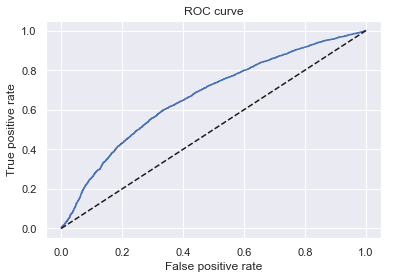

In [59]:
# plotting the ROC
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [60]:
AUROC_lgd = roc_auc_score(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])
AUROC_lgd

0.6679708699000835

This model is our baseline LGD model

### Saving the Model

In [61]:
import pickle

We will save the results of the stage 1 estimation model using pickle

In [62]:
pickle.dump(reg_lgd_st_1, open('lgd_model_stage_1.sav', 'wb'))

### Stage 2 – Linear Regression

In this stage we only take rows where there is a positive recovery rate ['recovery_rate'] == 1.  We are interested in the question "when there is a positive recovery rate, what is it likely to be?". How much bigger than 0?

In [63]:
lgd_stage_2_data = loan_data_defaults[loan_data_defaults['recovery_rate_0_1'] == 1]

We have filtered the population on positive recovery rate and need to perform a test train split on this new population.

In [64]:
lgd_inputs_stage_2_train, lgd_inputs_stage_2_test, lgd_targets_stage_2_train, lgd_targets_stage_2_test = train_test_split(lgd_stage_2_data.drop(['recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1), lgd_stage_2_data['recovery_rate'], test_size = 0.2, random_state = 42)

Analagous to the Logistic Regression Calculations in notebook 02:

In [65]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [66]:
import scipy.stats as stat

class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """
    
    # nothing changes in __init__
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1):
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs

    
    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        
        # Calculate SSE (sum of squared errors)
        # and SE (standard error)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])

        # compute the t-statistic for each feature
        self.t = self.coef_ / se
        # find the p-value for each feature
        self.p = np.squeeze(2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1])))
        return self

In [67]:
import scipy.stats as stat

class LinearRegression(linear_model.LinearRegression):
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1):
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs
    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])
        self.t = self.coef_ / se
        self.p = np.squeeze(2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1])))
        return self

We only need to keep the features we intend to use [features_all] is the list

In [68]:
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train[features_all]

We remove the Dummy Reference Classes to prevent multi-collinearity.  These are the classes with the smallest / most negative WoE within a feature, consistent with a conservative approach to Risk Management

In [69]:
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train.drop(features_reference_cat, axis = 1)

Let's estimate the coefficients for a logistic regression using the features in lgd_inputs_stage_2_train (X) with lgd_targets_stage_2_train as the target variable (y)

In [70]:
reg_lgd_st_2 = LinearRegression()
reg_lgd_st_2.fit(lgd_inputs_stage_2_train, lgd_targets_stage_2_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Create a list of the column names to use in the summary table 

In [71]:
feature_name = lgd_inputs_stage_2_train.columns.values

Create a summary table for features, coefficients and p-values 

In [72]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_lgd_st_2.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_lgd_st_2.intercept_]
summary_table = summary_table.sort_index()
p_values = reg_lgd_st_2.p
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values.round(3)
summary_table

,Feature name,Coefficients,p_values
0,Intercept,2.579796e-01,NaN
1,grade:A,-7.687368e-02,0.000
2,grade:B,-6.001154e-02,0.000
3,grade:C,-4.657851e-02,0.000
4,grade:D,-3.586545e-02,0.000
5,grade:E,-2.144822e-02,0.000
6,grade:F,-1.320832e-02,0.006
7,home_ownership:MORTGAGE,2.562511e-03,0.086
8,home_ownership:NONE,3.267286e-01,0.000
9,home_ownership:OTHER,4.059935e-02,0.025


In [73]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_lgd_st_2.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_lgd_st_2.intercept_]
summary_table = summary_table.sort_index()
p_values = reg_lgd_st_2.p
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values.round(3)
summary_table

,Feature name,Coefficients,p_values
0,Intercept,2.579796e-01,NaN
1,grade:A,-7.687368e-02,0.000
2,grade:B,-6.001154e-02,0.000
3,grade:C,-4.657851e-02,0.000
4,grade:D,-3.586545e-02,0.000
5,grade:E,-2.144822e-02,0.000
6,grade:F,-1.320832e-02,0.006
7,home_ownership:MORTGAGE,2.562511e-03,0.086
8,home_ownership:NONE,3.267286e-01,0.000
9,home_ownership:OTHER,4.059935e-02,0.025


### Stage 2 – Linear Regression Evaluation

We only use the variables we need, using the features_all list of columns.

In [74]:
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test[features_all]

Drop the reference class categories, those with the lowest WoE for a given feature

In [75]:
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test.drop(features_reference_cat, axis = 1)

In [76]:
lgd_inputs_stage_2_test.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

Calculate Predicted Values y^ based on the input features

In [77]:
y_hat_test_lgd_stage_2 = reg_lgd_st_2.predict(lgd_inputs_stage_2_test)

In [78]:
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test

In [79]:
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test_temp.reset_index(drop = True)

Calculate the correlation between actual and predicted values. 
Check the correlations

In [80]:
pd.concat([lgd_targets_stage_2_test_temp, pd.DataFrame(y_hat_test_lgd_stage_2)], axis = 1).corr()

,recovery_rate,0
recovery_rate,1.0000,0.2891
0,0.2891,1.0000


Plotting the residuals for the recovery rate residuals

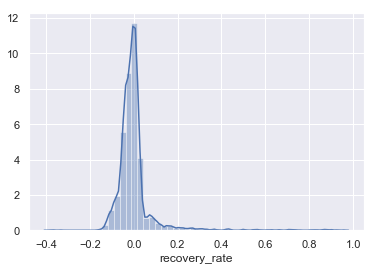

In [81]:
sns.distplot(lgd_targets_stage_2_test - y_hat_test_lgd_stage_2)

Save the LGD model down as a pickle file to reuse later

In [82]:
pickle.dump(reg_lgd_st_2, open('lgd_model_stage_2.sav', 'wb'))

### Combining Stage 1 and Stage 2

In [83]:
y_hat_test_lgd_stage_2_all = reg_lgd_st_2.predict(lgd_inputs_stage_1_test)

In [84]:
y_hat_test_lgd_stage_2_all

array([0.10229356, 0.09781694, 0.10890403, ..., 0.11744064, 0.09416444,
       0.1572757 ])

Combining the two stages of the model, logistic is RR 0 * multi-variate regression for RR

In [85]:
y_hat_test_lgd = y_hat_test_lgd_stage_1 * y_hat_test_lgd_stage_2_all

Let's take a look at the summary statistics for fitted LGD. It is bounded by [0,1] so values outside this range need to be adjusted.

In [86]:
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,8648.000000
mean,0.072112
std,0.052798
min,-0.008082
25%,0.000000
50%,0.089570
75%,0.114255
max,0.194768


Let's adjust the negative values to 0, and recheck

In [87]:
y_hat_test_lgd = np.where(y_hat_test_lgd < 0, 0, y_hat_test_lgd)
y_hat_test_lgd = np.where(y_hat_test_lgd > 1, 1, y_hat_test_lgd)
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,8648.000000
mean,0.072114
std,0.052796
min,0.000000
25%,0.000000
50%,0.089570
75%,0.114255
max,0.194768


In [88]:
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,8648.000000
mean,0.072114
std,0.052796
min,0.000000
25%,0.000000
50%,0.089570
75%,0.114255
max,0.194768


# EAD Model

### Estimation and Interpretation

As we have a new sample filtering on Defaulted Loans only we need to run a new test train split:

In [89]:
ead_inputs_train, ead_inputs_test, ead_targets_train, ead_targets_test = train_test_split(loan_data_defaults.drop(['recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1), loan_data_defaults['CCF'], test_size = 0.2, random_state = 42)

In [90]:
ead_inputs_train.columns.values

array(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan',
       'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim', 'vix_mean', 'vix_min', 'vix_max', 'vix_spread',
       'year

We only want to keep the features that we will be used

In [91]:
ead_inputs_train = ead_inputs_train[features_all]

Dropping the reference class dummies for each feature, selected as those the lowest WoE per feature, inline with prudent risk management. (prevent multi-collinearity)

In [92]:
ead_inputs_train = ead_inputs_train.drop(features_reference_cat, axis = 1)

Let's estimate the coefficients for EAD using the ead_inputs_train (X) and ead_target_train (y)

In [93]:
reg_ead = LinearRegression()
reg_ead.fit(ead_inputs_train, ead_targets_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [94]:
feature_name = ead_inputs_train.columns.values

Create a summary table displaying feature name, coefficients and p-values

In [95]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_ead.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_ead.intercept_]
summary_table = summary_table.sort_index()
p_values = reg_ead.p
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table

,Feature name,Coefficients,p_values
0,Intercept,1.112135e+00,NaN
1,grade:A,-2.970191e-01,0.000000e+00
2,grade:B,-2.331613e-01,0.000000e+00
3,grade:C,-1.702234e-01,0.000000e+00
4,grade:D,-1.181459e-01,0.000000e+00
5,grade:E,-6.680344e-02,0.000000e+00
6,grade:F,-1.954167e-02,6.843319e-03
7,home_ownership:MORTGAGE,-7.127335e-03,7.659612e-04
8,home_ownership:NONE,1.691132e-02,7.810387e-01
9,home_ownership:OTHER,-8.132621e-02,1.116661e-02


In [96]:
ead_inputs_train, ead_inputs_test, ead_targets_train, ead_targets_test = train_test_split(loan_data_defaults.drop(['recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1), loan_data_defaults['CCF'], test_size = 0.2, random_state = 42)

In [97]:
features_all_1 = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:MORTGAGE',
'home_ownership:NONE',
'home_ownership:OTHER',
'home_ownership:OWN',
'home_ownership:RENT',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'initial_list_status:f',
'initial_list_status:w',
'term_int',
'mths_since_issue_d',
'mths_since_earliest_cr_line',
'int_rate',
'annual_inc',
'delinq_2yrs',
'inq_last_6mths',
'open_acc',
'total_acc',
'total_rev_hi_lim'
]

In [98]:
features_reference_cat_1 = ['grade:G',
'home_ownership:RENT',
'purpose:credit_card',
'initial_list_status:f']

In [99]:
ead_inputs_train = ead_inputs_train[features_all_1]
ead_inputs_train = ead_inputs_train.drop(features_reference_cat_1, axis = 1)

In [100]:
reg_ead = LinearRegression()
reg_ead.fit(ead_inputs_train, ead_targets_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [101]:
feature_name = ead_inputs_train.columns.values
feature_name_ead = ead_inputs_train.columns.values

In [102]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_ead.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_ead.intercept_]
summary_table = summary_table.sort_index()
p_values = reg_ead.p
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table

,Feature name,Coefficients,p_values
0,Intercept,1.100759e+00,NaN
1,grade:A,-2.983794e-01,0.000000e+00
2,grade:B,-2.343434e-01,0.000000e+00
3,grade:C,-1.703192e-01,0.000000e+00
4,grade:D,-1.173972e-01,0.000000e+00
5,grade:E,-6.575558e-02,0.000000e+00
6,grade:F,-1.893929e-02,8.400892e-03
7,home_ownership:MORTGAGE,-8.653477e-03,3.692381e-05
8,home_ownership:NONE,1.500907e-02,8.053946e-01
9,home_ownership:OTHER,-7.986966e-02,1.281738e-02


The above model is the baseline model for LGD:

Intuition:
Negative Coefficents mean that losses decrease as the feature increases
Positive Coefficients mean that losses decrease as the feature increases

Key Points:
    
We can see that for the classed variables LGD decrease for borrowers with morgages and on high incomes: 
    * home_ownership:MORTGAGE -7.127335e-03
    * annual_inc              -9.341660e-11
    
For weddings the LGD increases:
    * purpose:weddings         3.569104e-02


### Model Validation

Keep only the variables we need

In [103]:
ead_inputs_test = ead_inputs_test[features_all_1]

Remove the reference class for each of the features - prevent multicollinearity and conservative from risk manangement viewpoint

In [104]:
ead_inputs_test = ead_inputs_test.drop(features_reference_cat_1, axis = 1)

In [105]:
ead_inputs_test.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'mths_since_issue_d',
       'mths_since_earliest_cr_line', 'int_rate', 'annual_inc',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'total_acc',
       'total_rev_hi_lim'], dtype=object)

In [106]:
ead_inputs_test.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'mths_since_issue_d',
       'mths_since_earliest_cr_line', 'int_rate', 'annual_inc',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'total_acc',
       'total_rev_hi_lim'], dtype=object)

### Run predictions for y^

In [107]:
y_hat_test_ead = reg_ead.predict(ead_inputs_test)

In [108]:
ead_targets_test_temp = ead_targets_test

In [109]:
ead_targets_test_temp = ead_targets_test_temp.reset_index(drop = True)

In [110]:
pd.concat([ead_targets_test_temp, pd.DataFrame(y_hat_test_ead)], axis = 1).corr()

,CCF,0
CCF,1.00000,0.53422
0,0.53422,1.00000


Errors have a good normally distributed shape

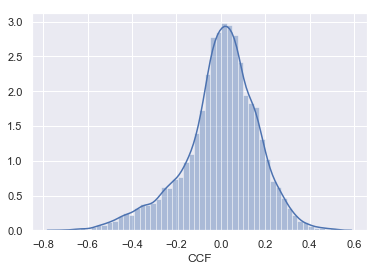

In [111]:
sns.distplot(ead_targets_test - y_hat_test_ead)

In [112]:
pd.DataFrame(y_hat_test_ead).describe()

,0
count,8648.000000
mean,0.736141
std,0.104969
min,0.330434
25%,0.663313
50%,0.731514
75%,0.810710
max,1.006570


In [113]:
y_hat_test_ead = np.where(y_hat_test_ead < 0, 0, y_hat_test_ead)
y_hat_test_ead = np.where(y_hat_test_ead > 1, 1, y_hat_test_ead)

In [114]:
pd.DataFrame(y_hat_test_ead).describe()

,0
count,8648.000000
mean,0.736140
std,0.104965
min,0.330434
25%,0.663313
50%,0.731514
75%,0.810710
max,1.000000


# Expected Loss
Expected Loss is the ultimate variable we wish to calculate.

In [115]:
loan_data_preprocessed.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,payment_to_inc
0,0,1077501,1296599,5000,5000,4975,36,10.65,162.869995,B,...,0,0,0,0,0,0,0,1,0,8.143500
1,1,1077430,1314167,2500,2500,2500,60,15.27,59.830002,C,...,0,0,0,0,0,0,0,1,0,2.393200
2,2,1077175,1313524,2400,2400,2400,36,15.96,84.330002,C,...,0,0,0,0,0,0,0,1,0,8.259549
3,3,1076863,1277178,10000,10000,10000,36,13.49,339.309998,C,...,0,0,0,0,0,0,0,1,0,8.275854
4,4,1075358,1311748,3000,3000,3000,60,12.69,67.790001,B,...,0,0,0,0,0,0,0,1,0,1.016850


In [116]:
loan_data_preprocessed['mths_since_last_delinq'].fillna(0, inplace = True)

In [117]:
loan_data_preprocessed['mths_since_last_record'].fillna(0, inplace = True)

We keep only the columns needed for the regression

In [118]:
loan_data_preprocessed_lgd_ead = loan_data_preprocessed[features_all]

Remove the reference class dummies for each of the features (prevent multi-collinearity & prudent risk management)

In [119]:
loan_data_preprocessed_lgd_ead = loan_data_preprocessed_lgd_ead.drop(features_reference_cat, axis = 1)

Apply stage 1 & Stage 2 of the LGD model and multiply them to give our LGD estimate

In [120]:
loan_data_preprocessed['recovery_rate_st_1'] = reg_lgd_st_1.model.predict(loan_data_preprocessed_lgd_ead)

In [121]:
loan_data_preprocessed['recovery_rate_st_2'] = reg_lgd_st_2.predict(loan_data_preprocessed_lgd_ead)

In [122]:
loan_data_preprocessed['recovery_rate'] = loan_data_preprocessed['recovery_rate_st_1'] * loan_data_preprocessed['recovery_rate_st_2']

Apply maxima of 0 & 1 to any recovery rate estimates outside the range of 0 & 1 

In [123]:
loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] < 0, 0, loan_data_preprocessed['recovery_rate'])
loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] > 1, 1, loan_data_preprocessed['recovery_rate'])

### Loss Given Default:

Estimated Loss Given Default = 1 - Estimated Recovery Rate 

In [124]:
loan_data_preprocessed['LGD'] = 1 - loan_data_preprocessed['recovery_rate']

In [125]:
loan_data_preprocessed['LGD'].describe()

count    466285.000000
mean          0.934239
std           0.058431
min           0.397445
25%           0.881971
50%           0.917335
75%           1.000000
max           1.000000
Name: LGD, dtype: float64

In [165]:
LGD = loan_data_preprocessed['LGD']

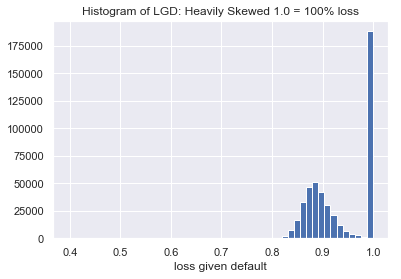

In [178]:
plt.hist(LGD,50)
plt.title(r'Histogram of LGD: Heavily Skewed 1.0 = 100% loss')
plt.xlabel('loss given default')
plt.show()

### Exposure at Default and the Credit Conversion Rate

Exposure at Default is a dollar amount that can be split into two components:

    1) The funded amount: the total of the customers loan facility - the maximum dollar amount
    2) The Credit Conversion Factor: Percentage of funded amount in use at the time of default 
        
We will calculate CCR using data in the customer loans datafram. As the funded amount and EAD are known by the bank it is relatively simple to calculate CRR. A simple nummeric example is the case where:

    A Customer has a credit card limit of USD $10,000 and goes into defaults owing $6,000
        
        CCR on the facility is 60%.
        EAD would be USD $10,000 * 60% = USD $6,000

CCR is our target variable and we run a multi-variate regression to estimate CCR_hat. 
Any CCF outliers with values above 1 or below 0 will need to be adjusted back within the range 0 - 1,

In [126]:
loan_data_preprocessed_ead = loan_data_preprocessed_lgd_ead[feature_name_ead]
#reg_ead.predict(loan_data_preprocessed)

In [127]:
loan_data_preprocessed['CCF'] = reg_ead.predict(loan_data_preprocessed_ead)

In [128]:
loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] < 0, 0, loan_data_preprocessed['CCF'])
loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] > 1, 1, loan_data_preprocessed['CCF'])

In [129]:
loan_data_preprocessed['EAD'] = loan_data_preprocessed['CCF'] * loan_data_preprocessed_lgd_ead['funded_amnt']

#### Descriptive statistics for Exposure at Default

In [130]:
loan_data_preprocessed['EAD'].describe()

count    466285.000000
mean      10799.756971
std        6886.816786
min         166.193525
25%        5505.279702
50%        9233.064339
75%       14671.696654
max       35000.000000
Name: EAD, dtype: float64

In [163]:
ead = loan_data_preprocessed['CCF']

In [181]:
ead.describe()

count    466285.000000
mean          0.737530
std           0.100939
min           0.279298
25%           0.671876
50%           0.730940
75%           0.802597
max           1.000000
Name: CCF, dtype: float64

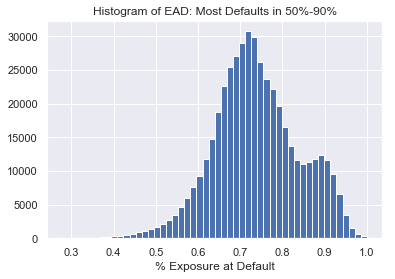

In [180]:
plt.hist(ead, 50)
plt.title(r'Histogram of EAD: Most Defaults in 50%-90%')
plt.xlabel('exposure at default')
plt.show()

In [131]:
loan_data_preprocessed.head(2)

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,addr_state:WY,initial_list_status:f,initial_list_status:w,payment_to_inc,recovery_rate_st_1,recovery_rate_st_2,recovery_rate,LGD,CCF,EAD
0,0,1077501,1296599,5000,5000,4975,36,10.65,162.869995,B,...,0,1,0,8.1435,1,0.084490,0.084490,0.915510,0.594188,2970.941252
1,1,1077430,1314167,2500,2500,2500,60,15.27,59.830002,C,...,0,1,0,2.3932,1,0.084346,0.084346,0.915654,0.772037,1930.092604


### Import the PD loan_data test train and test data from notebook 03

To calculate the capital calculations we all loans, so we combine the training and test sets.

Import and the loan_data_inputs_ train & loan_data_inputs_test dataframes (generated in notebook 03) ???

In [132]:
loan_data_inputs_train = pd.read_pickle('../data/loan_data_inputs_train.pkl')

In [133]:
loan_data_inputs_test = pd.read_pickle('../data/loan_data_inputs_test.pkl')

Join the two dataframes

In [134]:
loan_data_inputs_pd = pd.concat([loan_data_inputs_train, loan_data_inputs_test], axis = 0)

In [135]:
loan_data_inputs_pd.shape

(466285, 369)

In [136]:
loan_data_inputs_pd.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,vix_min:13.31-14.07,vix_min:14.07-14.81,vix_min:14.81-16.30,vix_min:>16.30,retail_sales_factor,retail_sales:<0.955,retail_sales:0.955-0.99,retail_sales:0.99-1.007,retail_sales:1.007-1.024,retail_sales:>1.024
427211,427184,12826297,14848419,6625,6625,6625,36,15.61,231.649994,C,...,1,0,0,0,"(1.007, 1.024]",0,0,0,1,0
206088,206089,1440029,1692050,7000,7000,7000,36,7.90,219.039993,A,...,1,0,0,0,"(0.972, 0.99]",0,1,0,0,0
136020,135855,5205057,6547237,8000,8000,8000,36,11.14,262.450012,B,...,0,0,0,0,"(0.99, 1.007]",0,0,1,0,0
412305,412302,11706104,13678263,5000,5000,5000,36,12.99,168.449997,B,...,0,0,0,0,"(1.024, 1.042]",0,0,0,0,1
36159,40943,445934,544945,15000,15000,14540,36,16.00,527.359985,D,...,0,0,0,1,"(0.868, 0.886]",1,0,0,0,0


In [137]:
loan_data_inputs_pd = loan_data_inputs_pd.set_index('Unnamed: 0')

In [138]:
loan_data_inputs_pd.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,vix_min:13.31-14.07,vix_min:14.07-14.81,vix_min:14.81-16.30,vix_min:>16.30,retail_sales_factor,retail_sales:<0.955,retail_sales:0.955-0.99,retail_sales:0.99-1.007,retail_sales:1.007-1.024,retail_sales:>1.024
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
427184,12826297,14848419,6625,6625,6625,36,15.61,231.649994,C,C5,...,1,0,0,0,"(1.007, 1.024]",0,0,0,1,0
206089,1440029,1692050,7000,7000,7000,36,7.90,219.039993,A,A4,...,1,0,0,0,"(0.972, 0.99]",0,1,0,0,0
135855,5205057,6547237,8000,8000,8000,36,11.14,262.450012,B,B2,...,0,0,0,0,"(0.99, 1.007]",0,0,1,0,0
412302,11706104,13678263,5000,5000,5000,36,12.99,168.449997,B,B5,...,0,0,0,0,"(1.024, 1.042]",0,0,0,0,1
40943,445934,544945,15000,15000,14540,36,16.00,527.359985,D,D5,...,0,0,0,1,"(0.868, 0.886]",1,0,0,0,0


#### The features below must be consistent with columns in the PD logistic regression

In [139]:
features_all_pd = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:OWN',
'home_ownership:MORTGAGE',
'addr_state:ND_NE_IA_NV_AL_FL_HI', 
'addr_state:MD_OK_MO_NC_LA_NM',                                                      
'addr_state:NY',
'addr_state:VA_TN_AZ_RI_NJ_UT',
'addr_state:CA',
'addr_state:PA_AR_MI_IN_KY',
'addr_state:MN_MA_DE_OH_SD',
'addr_state:CR_WA_GA_VM',
'addr_state:SC_IL_CT',
'addr_state:TX',
'addr_state:CO_AK_MT_KS_VT',          
'addr_state:ID_NH_MS_WY_DC_WV_ME',
'purpose:debt_consolidation',                                                    
'purpose:credit_card',                                                    
'purpose:educ__sm_b__ren_en__mov__house',
'purpose:oth__med__vacation',
'purpose:major_purch__car__home_impr',
'initial_list_status:w',
'initial_list_status:f',                                                    
'verification_status:Verified',                                 
'verification_status:Source Verified',                                                   
'verification_status:Not Verified',                 
'term:36',
'term:60',
'emp_length:0',
'emp_length:1',
'emp_length:2-4',
'emp_length:5-6',
'emp_length:7-9',
'emp_length:10',
'mths_since_issue_d:<38',
'mths_since_issue_d:38-39',
'mths_since_issue_d:40-41',
'mths_since_issue_d:42-48',
'mths_since_issue_d:49-52',
'mths_since_issue_d:53-64',
'mths_since_issue_d:65-84',
'mths_since_issue_d:>84',
'int_rate:<=9.5',
'int_rate:9.5-12.0',
'int_rate:12.0-15.75',
'int_rate:15.75-20.25',
'int_rate:>20.25',
'funded_amnt:<5675',
'funded_amnt:5675-7400',
'funded_amnt:7400-10850',
'funded_amnt:10850-16025',
'funded_amnt:>16025',
'mths_since_earliest_cr_line:<145',
'mths_since_earliest_cr_line:145-182',
'mths_since_earliest_cr_line:182-255',
'mths_since_earliest_cr_line:255-292',
'mths_since_earliest_cr_line:292-382',
'mths_since_earliest_cr_line:>382',
'inq_last_6mths:0',
'inq_last_6mths:1-2',
'inq_last_6mths:3',
'inq_last_6mths:>4',
'total_acc:<=5',
'total_acc:5-10',
'total_acc:10-15',
'total_acc:16-20',
'total_acc:20-31',
'total_acc:32-47',
'total_acc:>47',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'payment_to_inc_factor:<1',
'payment_to_inc_factor:1-2',
'payment_to_inc_factor:2-4',
'payment_to_inc_factor:4-6',
'payment_to_inc_factor:6-8',
'payment_to_inc_factor:8-11',
'payment_to_inc_factor:11-15',
'payment_to_inc_factor:>15',                    
'dti:<=1.4',
'dti:1.4-3.5', 
'dti:3.5-7.7', 
'dti:7.7-10.5',
'dti:10.5-16.1',
'dti:16.1-21.0',
'dti:21.0-23.8',
'dti:23.8-35.0',
'dti:>35',
'mths_since_last_record:Missing',
'mths_since_last_record:0-2',
'mths_since_last_record:3-20',
'mths_since_last_record:21-31',
'mths_since_last_record:32-80',
'mths_since_last_record:81-86',
'mths_since_last_record:>86',
'retail_sales:<0.955',
'retail_sales:0.955-0.99',
'retail_sales:0.99-1.007',
'retail_sales:1.007-1.024',
'retail_sales:>1.024'
        ]

In [140]:
ref_categories_pd = ['grade:G',
                  'home_ownership:RENT_OTHER_NONE_ANY',
                  'addr_state:ND_NE_IA_NV_AL_FL_HI', 
                  'purpose:educ__sm_b__ren_en__mov__house',
                  'verification_status:Verified',
                  'initial_list_status:w',
                  'term:60',
                  'emp_length:0',
                  'mths_since_issue_d:>84',
                  'int_rate:>20.25',
                  'funded_amnt:>16025',
                  'mths_since_earliest_cr_line:<145',
                  'inq_last_6mths:>4',
                  'total_acc:5-10',
                  'annual_inc:<20K',
                  'payment_to_inc_factor:>15', 
                  'dti:>35',
                  'mths_since_last_record:0-2',
                  'retail_sales:0.955-0.99',
                 ]

Keeping just the columns that we need

In [141]:
cols = loan_data_inputs_pd.columns
len(cols)

368

In [142]:
loan_data_inputs_pd_temp = loan_data_inputs_pd[features_all_pd]

Removing the reference classes for each feature (to prevent multi-collinearity)

In [143]:
loan_data_inputs_pd_temp = loan_data_inputs_pd_temp.drop(ref_categories_pd, axis = 1)

In [144]:
loan_data_inputs_pd_temp.shape

(466285, 97)

In [145]:
class LogisticRegression_with_p_values:
    
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)#,**args)

    def fit(self,X,y):
        self.model.fit(X,y)
        
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores] ### two tailed test for p-values
        
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        #self.z_scores = z_scores
        self.p_values = p_values
        #self.sigma_estimates = sigma_estimates
        #self.F_ij = F_ij


Import the PD model saved down as 'pd_model.sav' from the xx_worksheet

In [146]:
reg_pd = pickle.load(open('pd_model.sav', 'rb'))

The dataset needs to be the same shape as the original matrix.  This is the key hurdle!!!
Good Housekeeping and tracking of columns, variables and classes is essential!!!!

In [147]:
reg_pd.model.predict_proba(loan_data_inputs_pd_temp)[: ][: , 0]

array([0.08224086, 0.0340093 , 0.07922299, ..., 0.08528675, 0.08389965,
       0.04370233])

Apply the PD model to the original data to calculate estimated default probabilities - we are almost there!!!!

In [148]:
loan_data_inputs_pd['PD'] = reg_pd.model.predict_proba(loan_data_inputs_pd_temp)[: ][: , 0]

In [149]:
loan_data_inputs_pd['PD'].head()

Unnamed: 0
427184    0.082241
206089    0.034009
135855    0.079223
412302    0.058222
40943     0.165764
Name: PD, dtype: float64

Let's look at some descriptive stats for Probability of Default:

In [150]:
loan_data_inputs_pd['PD'].describe()

count    466285.000000
mean          0.082391
std           0.056360
min           0.004649
25%           0.041973
50%           0.068688
75%           0.108443
max           0.593230
Name: PD, dtype: float64

Now let's start putting everything we need to calculate EL into a single dataframe:

    All the required PD information is contained in the dataframe loan_data_inputs_pd
    All the EAD and LGD information is contained in the dataframe loan_data_preprocessed
    
Let's concatenate and calculate:

In [151]:
loan_data_preprocessed_new = pd.concat([loan_data_preprocessed, loan_data_inputs_pd], axis = 1)

In [152]:
loan_data_preprocessed_new.shape

(466285, 570)

In [153]:
loan_data_preprocessed_new.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,vix_min:14.07-14.81,vix_min:14.81-16.30,vix_min:>16.30,retail_sales_factor,retail_sales:<0.955,retail_sales:0.955-0.99,retail_sales:0.99-1.007,retail_sales:1.007-1.024,retail_sales:>1.024,PD
0,0,1077501,1296599,5000,5000,4975,36,10.65,162.869995,B,...,0,0,1,"(0.955, 0.972]",0,1,0,0,0,0.093858
1,1,1077430,1314167,2500,2500,2500,60,15.27,59.830002,C,...,0,0,1,"(0.955, 0.972]",0,1,0,0,0,0.120687
2,2,1077175,1313524,2400,2400,2400,36,15.96,84.330002,C,...,0,0,1,"(0.955, 0.972]",0,1,0,0,0,0.222518
3,3,1076863,1277178,10000,10000,10000,36,13.49,339.309998,C,...,0,0,1,"(0.955, 0.972]",0,1,0,0,0,0.160666
4,4,1075358,1311748,3000,3000,3000,60,12.69,67.790001,B,...,0,0,1,"(0.955, 0.972]",0,1,0,0,0,0.132906


Now let's create a new variable for Expected Loss: EL = PD * EAD * LGD 

In [154]:
loan_data_preprocessed_new['EL'] = loan_data_preprocessed_new['PD'] * loan_data_preprocessed_new['LGD'] * loan_data_preprocessed_new['EAD']

Let's get some descriptive statistics for Expected Loss, and see how reasonable they look:

In [155]:
loan_data_preprocessed_new['EL'].describe()

count    466285.000000
mean        801.978265
std         799.654585
min           7.157965
25%         278.334466
50%         551.221544
75%        1043.997743
max       13954.949046
Name: EL, dtype: float64

And let's see how the 4 key variables look in a dataframe. Funded amount is the amount of loan outstanding / available to the borrower. Capital is expressed as a percentage of funded amount so it is needed for context

In [156]:
loan_data_preprocessed_new[['funded_amnt', 'PD', 'LGD', 'EAD', 'EL']].head()

,funded_amnt,funded_amnt,PD,LGD,EAD,EL
0,5000,5000,0.093858,0.915510,2970.941252,255.286574
1,2500,2500,0.120687,0.915654,1930.092604,213.290064
2,2400,2400,0.222518,0.915714,1603.803719,326.795722
3,10000,10000,0.160666,0.906690,6663.364325,970.682163
4,3000,3000,0.132906,0.912752,2139.094281,259.494916


In [157]:
loan_data_preprocessed_new['funded_amnt'].describe()

,funded_amnt,funded_amnt
count,466285.000000,466285.000000
mean,14291.801044,14291.801044
std,8274.371300,8274.371300
min,500.000000,500.000000
25%,8000.000000,8000.000000
50%,12000.000000,12000.000000
75%,20000.000000,20000.000000
max,35000.000000,35000.000000


The Total Expected Loss across the loan portfolio is:

In [158]:
total_expected_loss = loan_data_preprocessed_new['EL'].sum()
print("The Total Expected Loss is: USD " + str(round(total_expected_loss/1000000,3)) + " million")
print("The Capital Requirement is: USD " + str(round(total_expected_loss/1000000,3)) + " million")

The Total Expected Loss is: USD 373.95 million
The Capital Requirement is: USD 373.95 million


The total funded amount across the loan portfolio is:

In [159]:
total_funded_amount = loan_data_preprocessed_new['funded_amnt'].sum()
print("The total funded amount is: USD " + str(round(total_funded_amount[1]/1000000,3)) + " million")

The total funded amount is: USD 6664.052 million


### The Capital Requirement Ratio for Expected Losses is:

In [160]:
capital_ratio = round((loan_data_preprocessed_new['EL'].sum()) / (loan_data_preprocessed_new['funded_amnt'].sum()),5)
print("The Capital Requirement Ratio is: " +str(capital_ratio[1] * 100) + "%")

The Capital Requirement Ratio is: 5.611%


### Work in Progress Section: Estimate Credit Score for a Customer making a New Loan Application

Build a function that takes features of a new loan application as inputs and returns a credit score .

Compares credit score to cutoff => with a yes / no answer. 
LEVERAGE THE CREDIT SCORE FUNCTION + CUTOFF FUNCTIONS in NB_03
Build in Dash

### Estimate the EL / Capital Requirement for a New Loan Application

Build function that generates the bank's marginal capital requirement for a new loan.
Build this in  Dash